In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
sys.path.append('~/Work/reflow')

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Fixing random state for reproducibility
np.random.seed(1234)


# Data preparation
Individual profile temperature stats are parsed from log files.
To be able to compare the results with recommended reflow profiles, we need to shift the time
values so that the start of the reflow profile is the same for both the example and the real one.

We calculate the relative value based on the first non-zero timer value of the controller (usually 15 seconds).

In [184]:
from parser import ReflowLogParser

p = ReflowLogParser('logs/2018-03-17 2.txt')
p.parse()

time_limit = (-30, 480)

reflows = []
times = []
for reflow in p.reflows:
    df = pd.DataFrame.from_records(
        reflow.get_reflow_profile(),
        columns=('Time', 'Timer', 'Temperature')
    )
    
    reference = df[df.Timer > 0].iloc[0]
    df['Relative'] = df.Time.apply(lambda x: int(round((x - reference.Time).total_seconds() + reference.Timer)))
    
    filtered = df[(df.Relative <= time_limit[1]) & (df.Relative >= time_limit[0])]
    reflows.append(filtered)
    times.append(reflow.date_reflow_started)
    
reflows[0].head()


,Time,Timer,Temperature,Relative
26,2019-03-17 20:33:04,0,40.78,-30
27,2019-03-17 20:33:05,0,41.39,-29
28,2019-03-17 20:33:06,0,41.86,-28
29,2019-03-17 20:33:07,0,42.39,-27
30,2019-03-17 20:33:08,0,42.89,-26


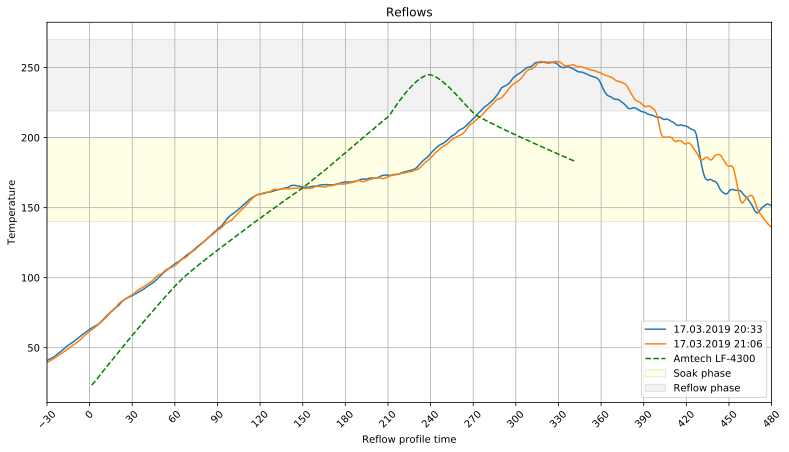

In [187]:
fig = plt.figure(figsize=(13, 7))

for reflow, time in zip(reflows, times):
    plt.plot(reflow.Relative, reflow.Temperature, label=time.strftime("%d.%m.%Y %H:%M"))

ref = pd.read_csv('reference/amtech lf-4300.csv', names=('time', 'temp'))
plt.plot(ref.time, ref.temp, label='Amtech LF-4300', color='g', linestyle='dashed')


ticks = list(np.arange(time_limit[0], time_limit[1] + 1, 30))
plt.xticks(ticks, rotation=45)

plt.xlabel("Reflow profile time")
plt.grid(True)

plt.axhspan(140, 200, facecolor='yellow', alpha=0.1, label='Soak phase', edgecolor='black')
plt.axhspan(219, 270, facecolor='gray', alpha=0.1, label='Reflow phase', edgecolor='black')

plt.xlim(*time_limit)
plt.ylabel("Temperature")
plt.title("Reflows")
plt.legend()
plt.show()